In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

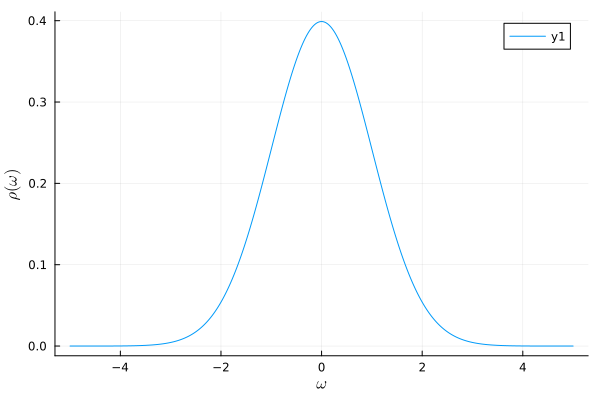

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = gaussian(omega, 0.0, 1.0)
omegas = LinRange(-5, 5, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+5
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [7]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 30
H=1
Iter     Function value   Gradient norm 
     0     6.439671e+00     2.172976e+01
 * time: 0.014531135559082031
     1     3.822590e+00     2.480912e+01
 * time: 1.1580901145935059
     2     1.770297e+00     1.585869e+01
 * time: 1.697939157485962
     3     6.430309e-01     2.198302e+00
 * time: 1.8914120197296143
     4     6.328597e-01     5.958198e-01
 * time: 1.9981729984283447
     5     6.321490e-01     5.876275e-02
 * time: 2.162061929702759
     6     6.321425e-01     1.458895e-02
 * time: 2.3390040397644043
     7     6.321421e-01     2.291596e-03
 * time: 2.550673007965088
     8     6.321421e-01     4.120384e-04
 * time: 2.7121291160583496
     9     6.321421e-01     6.409618e-05
 * time: 2.8332221508026123
    10     6.321421e-01     1.774856e-05
 * time: 3.038409948348999
    11     6.321421e-01     4.700377e-06
 * time: 3.246124029159546
    12     6.321421e-01     1.043518e-06
 * time: 3.3938839435577393
    13     6.321421e-01     1.946276e-

In [8]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     6.321421e-01     2.488322e-09
 * time: 0.0001819133758544922
max_theta=0.2413068658314274438128452044758003171137
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     6.321421e-01     5.977476e+00
 * time: 4.100799560546875e-5
     1     6.112807e-01     4.749639e+00
 * time: 0.31687211990356445
     2     3.799155e-01     6.547863e+00
 * time: 0.7273509502410889
     3     3.350864e-01     5.871248e+00
 * time: 0.8790180683135986
     4     1.681685e-01     4.601113e+00
 * time: 1.0356390476226807
     5     1.261112e-01     9.732258e-01
 * time: 1.15397310256958
     6     1.204342e-01     1.996414e-01
 * time: 1.3056299686431885
     7     1.201045e-01     6.040544e-02
 * time: 1.4575309753417969
     8     1.200794e-01     2.031200e-02
 * time: 1.611504077911377
     9     1.200787e-01     4.889113e-03
 * time: 1.814424991607666
    10     1.200786e-01     1.180051e-03
 * time: 2.018134117126

     9     3.507886e-04     3.715379e-02
 * time: 1.6831250190734863
    10     3.468452e-04     1.414882e-02
 * time: 1.866508960723877
    11     3.217835e-04     4.217862e-02
 * time: 2.165126085281372
    12     2.580796e-04     1.051078e-01
 * time: 2.4317729473114014
    13     1.133734e-04     4.555097e-02
 * time: 2.7241899967193604
    14     1.037168e-04     2.379553e-02
 * time: 2.984503984451294
    15     1.023646e-04     1.297748e-02
 * time: 3.291827917098999
    16     1.021204e-04     3.346797e-03
 * time: 3.4795169830322266
    17     1.020586e-04     1.581882e-03
 * time: 3.74359393119812
    18     1.020312e-04     2.016552e-03
 * time: 4.044364929199219
    19     1.020148e-04     1.522253e-03
 * time: 4.303153991699219
    20     1.020020e-04     1.233791e-03
 * time: 4.5979530811309814
    21     1.019929e-04     6.424480e-04
 * time: 4.8587870597839355
    22     1.019902e-04     9.545281e-04
 * time: 5.131010055541992
    23     1.019793e-04     1.920974e-03
 *

    21     3.175223e-05     2.278144e-02
 * time: 4.675688028335571
    22     3.017210e-05     2.855312e-02
 * time: 4.980219125747681
    23     2.874737e-05     2.880778e-02
 * time: 5.323681116104126
    24     2.659989e-05     2.072060e-02
 * time: 5.625219106674194
    25     2.505836e-05     7.086537e-03
 * time: 5.9471940994262695
    26     2.493117e-05     4.305577e-03
 * time: 6.145982027053833
    27     2.486333e-05     1.642664e-03
 * time: 6.347995042800903
    28     2.485253e-05     9.315910e-04
 * time: 6.563719034194946
    29     2.484995e-05     3.704927e-04
 * time: 6.779067039489746
    30     2.484935e-05     2.559269e-04
 * time: 7.120030164718628
    31     2.484866e-05     3.647603e-04
 * time: 7.446899175643921
    32     2.484799e-05     4.398461e-04
 * time: 7.6752049922943115
    33     2.484710e-05     6.250179e-04
 * time: 7.976547002792358
    34     2.484597e-05     7.826775e-04
 * time: 8.309086084365845
    35     2.484430e-05     9.506810e-04
 * ti

    63     2.198043e-05     3.959914e-04
 * time: 18.131230115890503
    64     2.198032e-05     4.665370e-04
 * time: 18.51145100593567
    65     2.198012e-05     5.752764e-04
 * time: 18.867937088012695
    66     2.197985e-05     6.727433e-04
 * time: 19.19066095352173
    67     2.197936e-05     8.051088e-04
 * time: 19.622282028198242
    68     2.197857e-05     8.921300e-04
 * time: 19.993984937667847
    69     2.197666e-05     7.610768e-04
 * time: 20.311372995376587
    70     2.197446e-05     3.629666e-04
 * time: 20.64837908744812
    71     2.197429e-05     7.088190e-05
 * time: 20.86079692840576
    72     2.197427e-05     3.073720e-05
 * time: 21.19756507873535
    73     2.197427e-05     2.581067e-05
 * time: 21.505445957183838
    74     2.197426e-05     6.253332e-06
 * time: 21.74406409263611
    75     2.197426e-05     3.411475e-06
 * time: 22.083261013031006
    76     2.197426e-05     2.299792e-06
 * time: 22.30512499809265
    77     2.197426e-05     1.214494e-06


    95     2.131735e-05     1.071056e-04
 * time: 27.866763830184937
    96     2.131734e-05     1.225476e-04
 * time: 28.145381927490234
    97     2.131733e-05     1.415270e-04
 * time: 28.545603036880493
    98     2.131732e-05     1.613136e-04
 * time: 28.77883791923523
    99     2.131731e-05     1.855475e-04
 * time: 29.13852095603943
   100     2.131729e-05     2.103976e-04
 * time: 29.467545986175537
   101     2.131727e-05     2.405124e-04
 * time: 29.839921951293945
   102     2.131724e-05     2.703604e-04
 * time: 30.33396601676941
   103     2.131719e-05     3.050938e-04
 * time: 30.73641800880432
   104     2.131713e-05     3.357020e-04
 * time: 31.10666799545288
   105     2.131703e-05     3.611188e-04
 * time: 31.51497483253479
   106     2.131686e-05     3.449180e-04
 * time: 31.883466005325317
   107     2.131644e-05     1.507963e-04
 * time: 32.23869490623474
   108     2.131634e-05     1.383051e-04
 * time: 32.46941685676575
   109     2.131630e-05     4.881243e-05
 

    87     2.116337e-05     8.937183e-04
 * time: 27.674378871917725
    88     2.116236e-05     1.104945e-03
 * time: 28.05022096633911
    89     2.116148e-05     1.142623e-03
 * time: 28.42503595352173
    90     2.115899e-05     1.162875e-03
 * time: 28.795969009399414
    91     2.115433e-05     6.918104e-04
 * time: 29.19408082962036
    92     2.115279e-05     5.903602e-04
 * time: 29.516238927841187
    93     2.115192e-05     2.733633e-04
 * time: 29.781852960586548
    94     2.115174e-05     1.445560e-04
 * time: 30.04418396949768
    95     2.115169e-05     9.909186e-05
 * time: 30.47134780883789
    96     2.115167e-05     6.636007e-05
 * time: 30.718527793884277
    97     2.115166e-05     3.739917e-05
 * time: 30.969209909439087
    98     2.115165e-05     2.226623e-05
 * time: 31.22214388847351
    99     2.115165e-05     1.470028e-05
 * time: 31.498833894729614
   100     2.115165e-05     9.020289e-06
 * time: 31.748377799987793
   101     2.115165e-05     5.541923e-06

    33     2.113850e-05     6.714628e-05
 * time: 11.806766986846924
    34     2.113834e-05     2.815847e-04
 * time: 12.176507949829102
    35     2.113820e-05     1.485214e-04
 * time: 12.58275294303894
    36     2.113805e-05     2.174715e-04
 * time: 13.024292945861816
    37     2.113793e-05     1.165892e-04
 * time: 13.48528504371643
    38     2.113788e-05     8.354824e-05
 * time: 13.886033058166504
    39     2.113786e-05     6.679523e-05
 * time: 14.286445140838623
    40     2.113785e-05     1.959300e-05
 * time: 14.546143054962158
    41     2.113785e-05     1.743172e-05
 * time: 14.95470905303955
    42     2.113785e-05     1.031931e-05
 * time: 15.213927984237671
    43     2.113785e-05     1.914216e-05
 * time: 15.620327949523926
    44     2.113785e-05     1.353877e-05
 * time: 15.875817060470581
    45     2.113784e-05     2.686551e-05
 * time: 16.28781509399414
    46     2.113784e-05     2.655102e-05
 * time: 16.541862964630127
    47     2.113784e-05     4.299491e-

   153     2.110941e-05     4.297343e-06
 * time: 50.219305992126465
   154     2.110941e-05     4.623430e-06
 * time: 50.48228311538696
   155     2.110941e-05     5.188623e-06
 * time: 50.772616147994995
   156     2.110941e-05     5.582624e-06
 * time: 51.03493905067444
   157     2.110941e-05     6.260367e-06
 * time: 51.292885065078735
   158     2.110941e-05     6.737144e-06
 * time: 51.557106018066406
   159     2.110941e-05     7.550141e-06
 * time: 51.85426306724548
   160     2.110941e-05     8.128138e-06
 * time: 52.11862397193909
   161     2.110941e-05     9.103696e-06
 * time: 52.52729105949402
   162     2.110941e-05     9.805968e-06
 * time: 52.78598093986511
   163     2.110941e-05     1.097700e-05
 * time: 53.193182945251465
   164     2.110941e-05     1.183269e-05
 * time: 53.45058012008667
   165     2.110941e-05     1.323882e-05
 * time: 53.846739053726196
   166     2.110941e-05     1.428520e-05
 * time: 54.09751605987549
   167     2.110941e-05     1.597394e-05
 

    75     2.110579e-05     1.092462e-05
 * time: 28.464035034179688
    76     2.110579e-05     1.906770e-05
 * time: 28.914615154266357
    77     2.110579e-05     1.786585e-05
 * time: 29.189173936843872
    78     2.110579e-05     2.674489e-05
 * time: 29.65232801437378
    79     2.110579e-05     2.532884e-05
 * time: 29.946604013442993
    80     2.110579e-05     3.959969e-05
 * time: 30.39623498916626
    81     2.110578e-05     3.833367e-05
 * time: 30.713889122009277
    82     2.110578e-05     5.267730e-05
 * time: 31.151000022888184
    83     2.110578e-05     5.087299e-05
 * time: 31.43428611755371
    84     2.110578e-05     7.591467e-05
 * time: 31.875898122787476
    85     2.110577e-05     7.430989e-05
 * time: 32.157480001449585
    86     2.110577e-05     9.707663e-05
 * time: 32.60495710372925
    87     2.110576e-05     9.456699e-05
 * time: 32.89161801338196
    88     2.110575e-05     1.387247e-04
 * time: 33.33387613296509
    89     2.110574e-05     1.369979e-04

   196     2.109842e-05     5.286053e-07
 * time: 73.61980104446411
   197     2.109842e-05     5.790732e-07
 * time: 73.90853214263916
   198     2.109842e-05     6.152362e-07
 * time: 74.21916913986206
   199     2.109842e-05     6.729739e-07
 * time: 74.64890694618225
   200     2.109842e-05     7.145201e-07
 * time: 74.99370813369751
   201     2.109842e-05     7.805511e-07
 * time: 75.30784511566162
   202     2.109842e-05     8.282466e-07
 * time: 75.65780210494995
   203     2.109842e-05     9.037534e-07
 * time: 75.95304012298584
   204     2.109842e-05     9.584886e-07
 * time: 76.26597595214844
   205     2.109842e-05     1.044836e-06
 * time: 76.61844205856323
   206     2.109842e-05     1.107655e-06
 * time: 77.02743911743164
   207     2.109842e-05     1.206387e-06
 * time: 77.3426160812378
   208     2.109842e-05     1.278484e-06
 * time: 77.64447903633118
   209     2.109842e-05     1.391344e-06
 * time: 77.92915916442871
   210     2.109842e-05     1.474075e-06
 * time:

    42     2.109797e-05     6.600362e-05
 * time: 15.919331073760986
    43     2.109797e-05     7.483966e-05
 * time: 16.27074098587036
    44     2.109796e-05     8.323784e-05
 * time: 16.577270984649658
    45     2.109796e-05     9.316945e-05
 * time: 16.89734697341919
    46     2.109795e-05     1.012265e-04
 * time: 17.2513370513916
    47     2.109794e-05     1.112620e-04
 * time: 17.55835509300232
    48     2.109794e-05     1.188777e-04
 * time: 17.87195611000061
    49     2.109793e-05     1.296299e-04
 * time: 18.222244024276733
    50     2.109792e-05     1.374480e-04
 * time: 18.58526301383972
    51     2.109791e-05     1.489129e-04
 * time: 19.17294692993164
    52     2.109790e-05     1.565341e-04
 * time: 19.51874303817749
    53     2.109789e-05     1.674321e-04
 * time: 20.135313034057617
    54     2.109788e-05     1.739816e-04
 * time: 20.540082931518555
    55     2.109786e-05     1.824071e-04
 * time: 21.188832998275757
    56     2.109785e-05     1.858725e-04
 *

   162     2.109733e-05     2.138674e-04
 * time: 60.75781202316284
   163     2.109732e-05     2.213888e-04
 * time: 61.19251489639282
   164     2.109731e-05     2.328287e-04
 * time: 61.701245069503784
   165     2.109729e-05     2.403981e-04
 * time: 62.02767300605774
   166     2.109728e-05     2.514100e-04
 * time: 62.52021408081055
   167     2.109726e-05     2.580521e-04
 * time: 63.01004505157471
   168     2.109723e-05     2.654125e-04
 * time: 63.57931900024414
   169     2.109718e-05     2.640710e-04
 * time: 64.09019804000854
   170     2.109706e-05     2.239373e-04
 * time: 64.64363598823547
   171     2.109669e-05     1.944759e-04
 * time: 65.32711696624756
   172     2.109663e-05     3.606647e-05
 * time: 65.69849610328674
   173     2.109662e-05     3.213884e-05
 * time: 66.19086003303528
   174     2.109662e-05     2.983848e-05
 * time: 66.70454406738281
   175     2.109662e-05     1.121239e-05
 * time: 67.01424312591553
   176     2.109662e-05     9.602044e-06
 * tim

    37     2.109529e-05     8.211270e-06
 * time: 17.03939700126648
    38     2.109529e-05     7.307436e-06
 * time: 17.41314697265625
    39     2.109529e-05     1.218463e-05
 * time: 18.21971082687378
    40     2.109529e-05     1.104459e-05
 * time: 18.728497982025146
    41     2.109529e-05     1.234821e-05
 * time: 19.61176586151123
    42     2.109529e-05     1.341502e-05
 * time: 20.17253088951111
    43     2.109529e-05     1.313573e-05
 * time: 20.773319005966187
    44     2.109529e-05     1.183437e-05
 * time: 21.344311952590942
    45     2.109529e-05     1.671340e-05
 * time: 21.91673183441162
    46     2.109529e-05     4.236288e-06
 * time: 22.3437979221344
    47     2.109529e-05     4.697597e-06
 * time: 22.722970962524414
    48     2.109529e-05     6.770780e-06
 * time: 23.328341960906982
    49     2.109529e-05     7.081264e-06
 * time: 23.69557499885559
    50     2.109529e-05     9.864967e-06
 * time: 24.11637592315674
    51     2.109529e-05     9.929835e-06
 * 

   158     2.109510e-05     1.909023e-05
 * time: 76.18451690673828
   159     2.109510e-05     1.854312e-05
 * time: 76.56126689910889
   160     2.109510e-05     2.327422e-05
 * time: 77.12185883522034
   161     2.109510e-05     2.247843e-05
 * time: 77.52359986305237
   162     2.109510e-05     3.096102e-05
 * time: 78.13352799415588
   163     2.109510e-05     3.040350e-05
 * time: 78.52187991142273
   164     2.109510e-05     3.689152e-05
 * time: 79.05445790290833
   165     2.109510e-05     3.553870e-05
 * time: 79.41190385818481
   166     2.109510e-05     4.839293e-05
 * time: 79.98063087463379
   167     2.109510e-05     4.773986e-05
 * time: 80.43320679664612
   168     2.109510e-05     6.017748e-05
 * time: 80.98203897476196
   169     2.109510e-05     5.924832e-05
 * time: 81.33166599273682
   170     2.109509e-05     7.351409e-05
 * time: 81.90465784072876
   171     2.109509e-05     7.245816e-05
 * time: 82.33765387535095
   172     2.109508e-05     9.324500e-05
 * time

     2     2.109448e-05     1.057604e-05
 * time: 1.34027099609375
     3     2.109448e-05     8.317421e-06
 * time: 1.732645034790039
     4     2.109448e-05     6.396614e-06
 * time: 2.092351198196411
     5     2.109448e-05     6.528324e-06
 * time: 2.4734489917755127
     6     2.109448e-05     5.115984e-06
 * time: 2.8483572006225586
     7     2.109448e-05     5.596476e-06
 * time: 3.232746124267578
     8     2.109448e-05     5.927602e-06
 * time: 3.587071180343628
     9     2.109448e-05     4.926801e-06
 * time: 3.9353442192077637
    10     2.109448e-05     8.426490e-06
 * time: 4.312741994857788
    11     2.109448e-05     6.822868e-06
 * time: 4.663955211639404
    12     2.109448e-05     9.429492e-06
 * time: 5.072486162185669
    13     2.109448e-05     5.154417e-06
 * time: 5.471175193786621
    14     2.109448e-05     4.785656e-06
 * time: 5.82420015335083
    15     2.109447e-05     5.980327e-06
 * time: 6.202006101608276
    16     2.109447e-05     8.743614e-06
 * tim

   122     2.109443e-05     4.540352e-05
 * time: 53.10293221473694
   123     2.109443e-05     4.718479e-05
 * time: 53.637235164642334
   124     2.109443e-05     5.012076e-05
 * time: 54.191506147384644
   125     2.109443e-05     5.201100e-05
 * time: 54.73324799537659
   126     2.109443e-05     5.551396e-05
 * time: 55.28623414039612
   127     2.109442e-05     5.497555e-05
 * time: 55.84468412399292
   128     2.109440e-05     3.782338e-05
 * time: 56.55986404418945
   129     2.109439e-05     2.246499e-05
 * time: 56.93723201751709
   130     2.109439e-05     1.471372e-05
 * time: 57.30176305770874
   131     2.109439e-05     7.804378e-06
 * time: 57.680984020233154
   132     2.109439e-05     1.155226e-05
 * time: 58.21030306816101
   133     2.109439e-05     5.706628e-06
 * time: 58.584267139434814
   134     2.109439e-05     3.394298e-06
 * time: 59.14374303817749
   135     2.109439e-05     2.211720e-06
 * time: 59.523733139038086
   136     2.109439e-05     2.389591e-06
 *

   243     2.109438e-05     3.711515e-06
 * time: 104.00283408164978
   244     2.109438e-05     3.754498e-06
 * time: 104.40654611587524
   245     2.109438e-05     4.047226e-06
 * time: 104.81322503089905
   246     2.109438e-05     4.094595e-06
 * time: 105.1816930770874
   247     2.109438e-05     4.408635e-06
 * time: 105.55822920799255
   248     2.109438e-05     4.460760e-06
 * time: 105.94630408287048
   249     2.109438e-05     4.797821e-06
 * time: 106.30738806724548
   250     2.109438e-05     4.855131e-06
 * time: 106.68864703178406
   251     2.109438e-05     5.216977e-06
 * time: 107.05529808998108
   252     2.109438e-05     5.279927e-06
 * time: 107.4528021812439
   253     2.109438e-05     5.668354e-06
 * time: 107.83861804008484
   254     2.109438e-05     5.737414e-06
 * time: 108.23771500587463
   255     2.109438e-05     6.154360e-06
 * time: 108.61008501052856
   256     2.109438e-05     6.230048e-06
 * time: 108.97959899902344
   257     2.109438e-05     6.677665

   363     2.109433e-05     6.899279e-06
 * time: 157.47102308273315
   364     2.109433e-05     6.656440e-06
 * time: 157.91948318481445
   365     2.109433e-05     8.068548e-06
 * time: 158.51479506492615
   366     2.109433e-05     7.720276e-06
 * time: 158.98694109916687
   367     2.109433e-05     9.524073e-06
 * time: 159.51941514015198
   368     2.109433e-05     9.152019e-06
 * time: 159.87749004364014
   369     2.109432e-05     1.154444e-05
 * time: 160.39411807060242
   370     2.109432e-05     1.101980e-05
 * time: 160.76602816581726
   371     2.109432e-05     1.335973e-05
 * time: 161.2844521999359
   372     2.109432e-05     1.270951e-05
 * time: 161.70579719543457
   373     2.109432e-05     1.684173e-05
 * time: 162.26661205291748
   374     2.109432e-05     1.614935e-05
 * time: 162.64476418495178
   375     2.109432e-05     1.934210e-05
 * time: 163.16210412979126
   376     2.109432e-05     1.836714e-05
 * time: 163.53479099273682
   377     2.109432e-05     2.48029

    50     2.109416e-05     4.432187e-06
 * time: 22.32781195640564
    51     2.109416e-05     7.662375e-06
 * time: 22.68301010131836
    52     2.109416e-05     2.461029e-06
 * time: 23.246698141098022
    53     2.109416e-05     2.687994e-06
 * time: 23.892457008361816
    54     2.109416e-05     2.318899e-06
 * time: 24.618831157684326
    55     2.109416e-05     7.468442e-07
 * time: 25.309903144836426
    56     2.109416e-05     4.290589e-06
 * time: 25.998005151748657
    57     2.109416e-05     2.551066e-06
 * time: 26.428856134414673
    58     2.109416e-05     5.245228e-06
 * time: 26.821264028549194
    59     2.109416e-05     3.206432e-06
 * time: 27.20363998413086
    60     2.109416e-05     5.598574e-06
 * time: 27.601997137069702
    61     2.109416e-05     3.976119e-06
 * time: 28.007081985473633
    62     2.109416e-05     6.619169e-06
 * time: 28.378474950790405
    63     2.109416e-05     5.216484e-06
 * time: 28.734513998031616
    64     2.109416e-05     7.719150e

   171     2.109413e-05     5.392132e-06
 * time: 82.314945936203
   172     2.109413e-05     6.751419e-06
 * time: 82.91824507713318
   173     2.109413e-05     6.502002e-06
 * time: 83.35109901428223
   174     2.109413e-05     7.880118e-06
 * time: 84.1297960281372
   175     2.109413e-05     7.623903e-06
 * time: 84.64805507659912
   176     2.109413e-05     9.141665e-06
 * time: 85.50429010391235
   177     2.109413e-05     8.798123e-06
 * time: 86.00236010551453
   178     2.109413e-05     1.076394e-05
 * time: 86.87291502952576
   179     2.109413e-05     1.030272e-05
 * time: 87.41289496421814
   180     2.109413e-05     1.224576e-05
 * time: 88.181223154068
   181     2.109413e-05     1.171434e-05
 * time: 88.58243703842163
   182     2.109413e-05     1.483379e-05
 * time: 89.19045495986938
   183     2.109413e-05     1.441347e-05
 * time: 89.65185213088989
   184     2.109413e-05     1.626489e-05
 * time: 90.35950899124146
   185     2.109413e-05     1.578655e-05
 * time: 90.

   291     2.109411e-05     7.754212e-06
 * time: 136.117849111557
   292     2.109411e-05     8.113827e-06
 * time: 136.53364992141724
   293     2.109411e-05     8.214856e-06
 * time: 136.92650198936462
   294     2.109411e-05     8.592379e-06
 * time: 137.33194398880005
   295     2.109411e-05     8.699202e-06
 * time: 137.72928309440613
   296     2.109411e-05     9.095659e-06
 * time: 138.11044096946716
   297     2.109411e-05     9.208593e-06
 * time: 138.53412795066833
   298     2.109411e-05     9.625100e-06
 * time: 138.9283721446991
   299     2.109411e-05     9.744482e-06
 * time: 139.34889602661133
   300     2.109411e-05     1.018225e-05
 * time: 139.74727511405945
   301     2.109411e-05     1.030843e-05
 * time: 140.14374113082886
   302     2.109411e-05     1.076876e-05
 * time: 140.55647015571594
   303     2.109411e-05     1.090213e-05
 * time: 140.93985199928284
   304     2.109411e-05     1.138639e-05
 * time: 141.34422898292542
   305     2.109411e-05     1.152736e

   411     2.109406e-05     1.597712e-07
 * time: 191.67098808288574
   412     2.109406e-05     1.904706e-07
 * time: 192.2587389945984
   413     2.109406e-05     1.819852e-07
 * time: 192.6686990261078
   414     2.109406e-05     2.147426e-07
 * time: 193.28615307807922
   415     2.109406e-05     2.066053e-07
 * time: 193.70868492126465
   416     2.109406e-05     2.415057e-07
 * time: 194.32087111473083
   417     2.109406e-05     2.338798e-07
 * time: 194.71599411964417
   418     2.109406e-05     2.707723e-07
 * time: 195.3458170890808
   419     2.109406e-05     2.632107e-07
 * time: 195.72902607917786
   420     2.109406e-05     3.022092e-07
 * time: 196.3125319480896
   421     2.109406e-05     2.942186e-07
 * time: 196.72219514846802
   422     2.109406e-05     3.358453e-07
 * time: 197.3242540359497
   423     2.109406e-05     3.274184e-07
 * time: 197.7180061340332
   424     2.109406e-05     3.721509e-07
 * time: 198.31861901283264
   425     2.109406e-05     3.636344e-07

   531     2.109405e-05     3.742954e-05
 * time: 254.53519797325134
   532     2.109405e-05     4.144093e-05
 * time: 255.15307211875916
   533     2.109405e-05     4.275585e-05
 * time: 255.7607080936432
   534     2.109403e-05     5.989331e-05
 * time: 256.5572941303253
   535     2.109403e-05     1.838725e-05
 * time: 256.9346010684967
   536     2.109402e-05     1.945793e-05
 * time: 257.5312111377716
   537     2.109402e-05     8.134052e-06
 * time: 257.91443514823914
   538     2.109402e-05     1.012491e-05
 * time: 258.5159330368042
   539     2.109402e-05     6.404027e-06
 * time: 258.91020011901855
   540     2.109402e-05     7.006094e-06
 * time: 259.5107579231262
   541     2.109402e-05     2.855385e-06
 * time: 259.89511013031006
   542     2.109402e-05     4.142653e-06
 * time: 260.5060329437256
   543     2.109402e-05     1.926851e-06
 * time: 260.8905019760132
   544     2.109402e-05     2.391007e-06
 * time: 261.50731110572815
   545     2.109402e-05     1.115667e-06
 

    85     2.109395e-05     7.692890e-06
 * time: 43.16815900802612
    86     2.109395e-05     4.697491e-06
 * time: 43.60221815109253
    87     2.109395e-05     9.888996e-06
 * time: 44.2100031375885
    88     2.109395e-05     7.360543e-06
 * time: 44.64658713340759
    89     2.109395e-05     1.059756e-05
 * time: 45.33175802230835
    90     2.109395e-05     8.265827e-06
 * time: 45.73452019691467
    91     2.109395e-05     1.303360e-05
 * time: 46.38300108909607
    92     2.109395e-05     1.104058e-05
 * time: 46.81578016281128
    93     2.109395e-05     1.447951e-05
 * time: 47.450642108917236
    94     2.109395e-05     1.242077e-05
 * time: 47.85427904129028
    95     2.109395e-05     1.705009e-05
 * time: 48.49345517158508
    96     2.109395e-05     1.532728e-05
 * time: 48.91236114501953
    97     2.109395e-05     1.923632e-05
 * time: 49.56079316139221
    98     2.109395e-05     1.779374e-05
 * time: 49.971291065216064
    99     2.109395e-05     2.158974e-05
 * tim

   206     2.109388e-05     1.100227e-06
 * time: 106.95045900344849
   207     2.109388e-05     1.356220e-06
 * time: 107.3476722240448
   208     2.109388e-05     1.294217e-06
 * time: 107.77262115478516
   209     2.109388e-05     1.550327e-06
 * time: 108.22401404380798
   210     2.109388e-05     1.513649e-06
 * time: 108.68326115608215
   211     2.109388e-05     1.759044e-06
 * time: 109.1423192024231
   212     2.109388e-05     1.735566e-06
 * time: 109.55147910118103
   213     2.109388e-05     1.970826e-06
 * time: 109.99526810646057
   214     2.109388e-05     1.951789e-06
 * time: 110.43162703514099
   215     2.109388e-05     2.185451e-06
 * time: 111.0139970779419
   216     2.109388e-05     2.170606e-06
 * time: 111.5978331565857
   217     2.109388e-05     2.408881e-06
 * time: 112.17431211471558
   218     2.109388e-05     2.400001e-06
 * time: 112.75411009788513
   219     2.109388e-05     2.646045e-06
 * time: 113.30996918678284
   220     2.109388e-05     2.644837e-

   326     2.109387e-05     4.515524e-05
 * time: 159.50883102416992
   327     2.109387e-05     4.697561e-05
 * time: 160.14163208007812
   328     2.109387e-05     4.756023e-05
 * time: 160.55092120170593
   329     2.109387e-05     4.955496e-05
 * time: 161.1808340549469
   330     2.109387e-05     5.020497e-05
 * time: 161.59689712524414
   331     2.109387e-05     5.242084e-05
 * time: 162.24355721473694
   332     2.109387e-05     5.316044e-05
 * time: 162.6445701122284
   333     2.109387e-05     5.567049e-05
 * time: 163.26174521446228
   334     2.109387e-05     5.654743e-05
 * time: 163.66859316825867
   335     2.109387e-05     5.947311e-05
 * time: 164.29307913780212
   336     2.109387e-05     6.060690e-05
 * time: 164.72237706184387
   337     2.109387e-05     6.413942e-05
 * time: 165.3387680053711
   338     2.109386e-05     6.596397e-05
 * time: 165.9635910987854
   339     2.109386e-05     6.916591e-05
 * time: 166.57199215888977
   340     2.109381e-05     7.163877e-

   446     2.109363e-05     4.789919e-05
 * time: 227.53075504302979
   447     2.109363e-05     2.400403e-05
 * time: 227.9403431415558
   448     2.109363e-05     2.742575e-05
 * time: 228.60146403312683
   449     2.109363e-05     1.577758e-05
 * time: 229.0154411792755
   450     2.109363e-05     1.757321e-05
 * time: 229.7040410041809
   451     2.109363e-05     7.145147e-06
 * time: 230.16221404075623
   452     2.109363e-05     1.139768e-05
 * time: 230.91760420799255
   453     2.109363e-05     6.148291e-06
 * time: 231.4534511566162
   454     2.109362e-05     6.760550e-06
 * time: 232.29887318611145
   455     2.109362e-05     3.244759e-06
 * time: 232.85492706298828
   456     2.109362e-05     4.279060e-06
 * time: 233.7332842350006
   457     2.109362e-05     2.004277e-06
 * time: 234.24458003044128
   458     2.109362e-05     2.945412e-06
 * time: 234.99496006965637
   459     2.109362e-05     1.217491e-06
 * time: 235.40949201583862
   460     2.109362e-05     1.771542e-0

   566     2.109356e-05     1.097057e-04
 * time: 292.8239641189575
   567     2.109356e-05     1.123938e-04
 * time: 293.3919861316681
   568     2.109354e-05     1.130751e-04
 * time: 294.1615722179413
   569     2.109350e-05     1.221096e-04
 * time: 295.0569291114807
   570     2.109341e-05     1.786062e-04
 * time: 295.79451608657837
   571     2.109336e-05     1.047933e-04
 * time: 296.19767022132874
   572     2.109332e-05     1.038932e-04
 * time: 296.81025314331055
   573     2.109330e-05     5.253493e-05
 * time: 297.2240262031555
   574     2.109328e-05     7.322646e-05
 * time: 297.84987616539
   575     2.109327e-05     3.378350e-05
 * time: 298.2658700942993
   576     2.109326e-05     4.550802e-05
 * time: 298.9060311317444
   577     2.109326e-05     2.034616e-05
 * time: 299.3119480609894
   578     2.109326e-05     3.037080e-05
 * time: 300.04615807533264
   579     2.109326e-05     1.447933e-05
 * time: 300.4910910129547
   580     2.109325e-05     1.778219e-05
 * ti

   686     2.109325e-05     1.059090e-05
 * time: 359.8456521034241
   687     2.109325e-05     9.867787e-06
 * time: 360.282457113266
   688     2.109325e-05     1.394440e-05
 * time: 360.97308707237244
   689     2.109325e-05     1.334833e-05
 * time: 361.4438021183014
   690     2.109325e-05     1.480867e-05
 * time: 362.10220313072205
   691     2.109325e-05     1.341053e-05
 * time: 362.56094002723694
   692     2.109325e-05     1.792748e-05
 * time: 363.23171615600586
   693     2.109325e-05     1.675777e-05
 * time: 363.7028570175171
   694     2.109325e-05     2.090696e-05
 * time: 364.36757612228394
   695     2.109325e-05     1.965646e-05
 * time: 364.83511114120483
   696     2.109325e-05     2.380987e-05
 * time: 365.48092818260193
   697     2.109325e-05     2.215816e-05
 * time: 365.9297091960907
   698     2.109325e-05     2.642410e-05
 * time: 366.5736072063446
   699     2.109325e-05     2.522035e-05
 * time: 366.9831850528717
   700     2.109325e-05     3.296868e-05
 

    21     2.109112e-05     1.331984e-05
 * time: 9.826914072036743
    22     2.109111e-05     3.602987e-05
 * time: 10.223607063293457
    23     2.109111e-05     1.840434e-05
 * time: 10.629448890686035
    24     2.109111e-05     2.033583e-05
 * time: 11.014736890792847
    25     2.109110e-05     1.670934e-05
 * time: 11.404653072357178
    26     2.109109e-05     2.046230e-05
 * time: 11.820003986358643
    27     2.109109e-05     1.381147e-05
 * time: 12.210624933242798
    28     2.109108e-05     2.081586e-05
 * time: 12.6095130443573
    29     2.109107e-05     2.886429e-05
 * time: 13.000366926193237
    30     2.109106e-05     1.783669e-05
 * time: 13.42098593711853
    31     2.109106e-05     2.042502e-05
 * time: 13.8194739818573
    32     2.109105e-05     1.761662e-05
 * time: 14.205862045288086
    33     2.109105e-05     3.055403e-05
 * time: 14.627574920654297
    34     2.109104e-05     3.381866e-05
 * time: 15.251970052719116
    35     2.109103e-05     2.475829e-05

   141     2.109067e-05     5.044881e-05
 * time: 68.36876201629639
   142     2.109067e-05     5.217103e-05
 * time: 68.82292604446411
   143     2.109067e-05     5.462433e-05
 * time: 69.44966506958008
   144     2.109067e-05     5.635044e-05
 * time: 69.87353205680847
   145     2.109067e-05     5.920492e-05
 * time: 70.52371311187744
   146     2.109067e-05     6.102244e-05
 * time: 71.00218105316162
   147     2.109067e-05     6.414532e-05
 * time: 71.72790002822876
   148     2.109067e-05     6.630006e-05
 * time: 72.16584706306458
   149     2.109066e-05     6.982500e-05
 * time: 72.75393795967102
   150     2.109066e-05     7.332910e-05
 * time: 73.34463000297546
   151     2.109064e-05     7.313545e-05
 * time: 74.28499794006348
   152     2.109056e-05     1.175207e-04
 * time: 75.18160009384155
   153     2.109054e-05     2.309776e-05
 * time: 75.62659096717834
   154     2.109053e-05     1.947183e-05
 * time: 76.23431396484375
   155     2.109053e-05     1.591928e-05
 * time

   262     2.109052e-05     3.730348e-05
 * time: 119.55052995681763
   263     2.109052e-05     3.736843e-05
 * time: 119.93290710449219
   264     2.109052e-05     3.876851e-05
 * time: 120.35698008537292
   265     2.109052e-05     3.883849e-05
 * time: 120.82917594909668
   266     2.109052e-05     4.028128e-05
 * time: 121.33824801445007
   267     2.109052e-05     4.035631e-05
 * time: 121.81806802749634
   268     2.109052e-05     4.184371e-05
 * time: 122.33427309989929
   269     2.109052e-05     4.192392e-05
 * time: 122.80777192115784
   270     2.109052e-05     4.345796e-05
 * time: 123.27853989601135
   271     2.109052e-05     4.354362e-05
 * time: 123.77364897727966
   272     2.109052e-05     4.512654e-05
 * time: 124.15085506439209
   273     2.109052e-05     4.521797e-05
 * time: 124.5720329284668
   274     2.109052e-05     4.685233e-05
 * time: 125.00123810768127
   275     2.109052e-05     4.694977e-05
 * time: 125.4027988910675
   276     2.109052e-05     4.863841

   382     2.109020e-05     7.290911e-06
 * time: 173.3331220149994
   383     2.109020e-05     7.687740e-06
 * time: 173.7359778881073
   384     2.109020e-05     7.714740e-06
 * time: 174.11862111091614
   385     2.109020e-05     8.117954e-06
 * time: 174.52237391471863
   386     2.109020e-05     8.148780e-06
 * time: 174.90973806381226
   387     2.109020e-05     8.558192e-06
 * time: 175.30359292030334
   388     2.109020e-05     8.593047e-06
 * time: 175.72173595428467
   389     2.109020e-05     9.008932e-06
 * time: 176.1220669746399
   390     2.109020e-05     9.047758e-06
 * time: 176.52347493171692
   391     2.109020e-05     9.470795e-06
 * time: 176.99260210990906
   392     2.109020e-05     9.513346e-06
 * time: 177.4927020072937
   393     2.109020e-05     9.944270e-06
 * time: 177.88937401771545
   394     2.109020e-05     9.990325e-06
 * time: 178.38213205337524
   395     2.109020e-05     1.042959e-05
 * time: 178.78965997695923
   396     2.109020e-05     1.047908e-

   502     2.109019e-05     6.626628e-05
 * time: 225.74238204956055
   503     2.109019e-05     6.794207e-05
 * time: 226.17594695091248
   504     2.109019e-05     6.835676e-05
 * time: 226.64622902870178
   505     2.109019e-05     7.009037e-05
 * time: 227.1099030971527
   506     2.109019e-05     7.052161e-05
 * time: 227.55071592330933
   507     2.109019e-05     7.231648e-05
 * time: 228.019061088562
   508     2.109019e-05     7.276526e-05
 * time: 228.48943495750427
   509     2.109019e-05     7.462520e-05
 * time: 229.05228400230408
   510     2.109019e-05     7.509261e-05
 * time: 229.45979499816895
   511     2.109019e-05     7.702187e-05
 * time: 229.93354105949402
   512     2.109019e-05     7.750915e-05
 * time: 230.52392101287842
   513     2.109019e-05     7.951246e-05
 * time: 230.966943025589
   514     2.109018e-05     8.002098e-05
 * time: 231.41797590255737
   515     2.109018e-05     8.210371e-05
 * time: 231.81595611572266
   516     2.109018e-05     8.263503e-0

   622     2.108940e-05     3.497414e-06
 * time: 285.0797519683838
   623     2.108940e-05     4.135827e-06
 * time: 285.6605739593506
   624     2.108940e-05     3.833965e-06
 * time: 286.0671660900116
   625     2.108940e-05     4.599156e-06
 * time: 286.6569290161133
   626     2.108940e-05     4.290902e-06
 * time: 287.05950903892517
   627     2.108940e-05     5.121919e-06
 * time: 287.6439459323883
   628     2.108940e-05     4.782225e-06
 * time: 288.0585289001465
   629     2.108940e-05     6.010427e-06
 * time: 288.65061712265015
   630     2.108940e-05     5.598004e-06
 * time: 289.03726410865784
   631     2.108940e-05     6.305305e-06
 * time: 289.63148403167725
   632     2.108940e-05     5.908628e-06
 * time: 290.02370595932007
   633     2.108940e-05     7.785877e-06
 * time: 290.61953997612
   634     2.108940e-05     7.444956e-06
 * time: 291.0143539905548
   635     2.108940e-05     7.955463e-06
 * time: 291.603718996048
   636     2.108940e-05     7.463797e-06
 * ti

   742     2.108864e-05     2.097380e-07
 * time: 346.69396805763245
   743     2.108864e-05     3.421381e-07
 * time: 347.28681206703186
   744     2.108864e-05     2.465039e-07
 * time: 347.70655488967896
   745     2.108864e-05     3.614014e-07
 * time: 348.31618309020996
   746     2.108864e-05     2.753422e-07
 * time: 348.70598101615906
   747     2.108864e-05     4.248685e-07
 * time: 349.3039960861206
   748     2.108864e-05     3.708303e-07
 * time: 349.69033098220825
   749     2.108864e-05     4.949418e-07
 * time: 350.2934761047363
   750     2.108864e-05     4.199256e-07
 * time: 350.67727398872375
   751     2.108864e-05     6.027923e-07
 * time: 351.27447509765625
   752     2.108864e-05     5.435420e-07
 * time: 351.66105103492737
   753     2.108864e-05     6.853789e-07
 * time: 352.27751302719116
   754     2.108864e-05     5.757701e-07
 * time: 352.6706221103668
   755     2.108864e-05     7.431130e-07
 * time: 353.26697301864624
   756     2.108864e-05     6.566788e

   862     2.108665e-05     4.594046e-04
 * time: 408.7827079296112
   863     2.108631e-05     1.900759e-04
 * time: 409.2033541202545
   864     2.108602e-05     1.683170e-04
 * time: 409.8897728919983
   865     2.108597e-05     1.268743e-04
 * time: 410.33636593818665
   866     2.108590e-05     1.512699e-04
 * time: 410.72940492630005
   867     2.108586e-05     1.000839e-04
 * time: 411.1227550506592
   868     2.108582e-05     1.028224e-04
 * time: 411.52652192115784
   869     2.108580e-05     6.892648e-05
 * time: 411.9211890697479
   870     2.108578e-05     8.134902e-05
 * time: 412.3496859073639
   871     2.108577e-05     5.718925e-05
 * time: 412.7667760848999
   872     2.108576e-05     6.567885e-05
 * time: 413.21887397766113
   873     2.108575e-05     4.163517e-05
 * time: 413.62720489501953
   874     2.108574e-05     4.837460e-05
 * time: 414.0196969509125
   875     2.108574e-05     3.092554e-05
 * time: 414.4529769420624
   876     2.108573e-05     3.882840e-05
 *

    42     2.108497e-05     9.876301e-05
 * time: 21.785188913345337
    43     2.108491e-05     5.741476e-05
 * time: 22.2597918510437
    44     2.108486e-05     9.008705e-05
 * time: 22.931617975234985
    45     2.108481e-05     5.573226e-05
 * time: 23.61939787864685
    46     2.108479e-05     6.112100e-05
 * time: 24.05848503112793
    47     2.108477e-05     6.013489e-05
 * time: 24.7461678981781
    48     2.108471e-05     5.194258e-05
 * time: 25.422783851623535
    49     2.108466e-05     3.856282e-05
 * time: 26.14583396911621
    50     2.108464e-05     4.663614e-05
 * time: 26.904013872146606
    51     2.108462e-05     8.290577e-05
 * time: 27.34680199623108
    52     2.108454e-05     1.097588e-04
 * time: 28.023478984832764
    53     2.108449e-05     7.677431e-05
 * time: 28.460458993911743
    54     2.108443e-05     8.830701e-05
 * time: 28.906471014022827
    55     2.108440e-05     4.418112e-05
 * time: 29.34555697441101
    56     2.108438e-05     5.320804e-05
 *

   163     2.108292e-05     1.137634e-04
 * time: 89.0975649356842
   164     2.108291e-05     1.473248e-04
 * time: 89.73454093933105
   165     2.108290e-05     1.182878e-04
 * time: 90.14510297775269
   166     2.108288e-05     1.467405e-04
 * time: 90.77347207069397
   167     2.108287e-05     1.208745e-04
 * time: 91.18294191360474
   168     2.108285e-05     1.303309e-04
 * time: 91.81499886512756
   169     2.108280e-05     1.425042e-04
 * time: 92.45209193229675
   170     2.108268e-05     1.935564e-04
 * time: 93.06932306289673
   171     2.108261e-05     8.851193e-05
 * time: 93.49523997306824
   172     2.108256e-05     1.086517e-04
 * time: 94.11561989784241
   173     2.108254e-05     6.063028e-05
 * time: 94.55134892463684
   174     2.108251e-05     8.232584e-05
 * time: 95.16420984268188
   175     2.108250e-05     4.965871e-05
 * time: 95.58870887756348
   176     2.108249e-05     5.540600e-05
 * time: 96.22854399681091
   177     2.108248e-05     3.072660e-05
 * time:

   283     2.108134e-05     2.352897e-06
 * time: 156.21672797203064
   284     2.108134e-05     3.438886e-06
 * time: 156.6503930091858
   285     2.108134e-05     2.142824e-06
 * time: 157.0663459300995
   286     2.108134e-05     3.323488e-06
 * time: 157.49215388298035
   287     2.108134e-05     2.207012e-06
 * time: 158.07402992248535
   288     2.108134e-05     3.422244e-06
 * time: 158.61723494529724
   289     2.108134e-05     2.444789e-06
 * time: 159.20985388755798
   290     2.108134e-05     3.651970e-06
 * time: 159.72995495796204
   291     2.108134e-05     2.804452e-06
 * time: 160.28780388832092
   292     2.108134e-05     3.921951e-06
 * time: 160.82773995399475
   293     2.108134e-05     3.214837e-06
 * time: 161.3491289615631
   294     2.108134e-05     4.223192e-06
 * time: 161.88459587097168
   295     2.108134e-05     3.633360e-06
 * time: 162.43165397644043
   296     2.108134e-05     4.569813e-06
 * time: 162.97372007369995
   297     2.108134e-05     4.068984e

   403     2.108133e-05     4.381077e-05
 * time: 208.66389203071594
   404     2.108133e-05     4.467958e-05
 * time: 209.0813808441162
   405     2.108133e-05     4.484032e-05
 * time: 209.5160050392151
   406     2.108133e-05     4.571696e-05
 * time: 209.93867897987366
   407     2.108133e-05     4.588200e-05
 * time: 210.35303497314453
   408     2.108133e-05     4.676666e-05
 * time: 210.78270387649536
   409     2.108133e-05     4.693597e-05
 * time: 211.1859269142151
   410     2.108133e-05     4.782887e-05
 * time: 211.62560606002808
   411     2.108133e-05     4.800241e-05
 * time: 212.03690195083618
   412     2.108133e-05     4.890373e-05
 * time: 212.47777485847473
   413     2.108133e-05     4.908148e-05
 * time: 212.98011898994446
   414     2.108133e-05     4.999137e-05
 * time: 213.4314398765564
   415     2.108133e-05     5.017331e-05
 * time: 213.8521740436554
   416     2.108133e-05     5.109275e-05
 * time: 214.26163506507874
   417     2.108133e-05     5.127815e-0

   523     2.108129e-05     1.320506e-04
 * time: 260.1225850582123
   524     2.108129e-05     1.336780e-04
 * time: 260.54671692848206
   525     2.108129e-05     1.340870e-04
 * time: 260.9561128616333
   526     2.108129e-05     1.357349e-04
 * time: 261.38799500465393
   527     2.108129e-05     1.361475e-04
 * time: 261.80863904953003
   528     2.108129e-05     1.378165e-04
 * time: 262.2282168865204
   529     2.108129e-05     1.382327e-04
 * time: 262.6689839363098
   530     2.108129e-05     1.399232e-04
 * time: 263.07280588150024
   531     2.108129e-05     1.403430e-04
 * time: 263.5000388622284
   532     2.108128e-05     1.420558e-04
 * time: 263.91588306427
   533     2.108128e-05     1.424789e-04
 * time: 264.3471579551697
   534     2.108128e-05     1.442146e-04
 * time: 264.75892901420593
   535     2.108128e-05     1.446411e-04
 * time: 265.1924979686737
   536     2.108128e-05     1.464006e-04
 * time: 265.62193298339844
   537     2.108128e-05     1.468301e-04
 * 

   644     2.107984e-05     3.150092e-06
 * time: 315.65123200416565
   645     2.107984e-05     3.760600e-06
 * time: 316.0760290622711
   646     2.107984e-05     3.455636e-06
 * time: 316.47873091697693
   647     2.107984e-05     4.059660e-06
 * time: 316.90182995796204
   648     2.107984e-05     3.768049e-06
 * time: 317.3272888660431
   649     2.107984e-05     4.362527e-06
 * time: 317.7512800693512
   650     2.107984e-05     4.084976e-06
 * time: 318.16154193878174
   651     2.107984e-05     4.667173e-06
 * time: 318.5958709716797
   652     2.107984e-05     4.405497e-06
 * time: 319.001816034317
   653     2.107984e-05     4.973822e-06
 * time: 319.408686876297
   654     2.107984e-05     4.729361e-06
 * time: 319.8373010158539
   655     2.107984e-05     5.284603e-06
 * time: 320.2488398551941
   656     2.107984e-05     5.057145e-06
 * time: 320.68751406669617
   657     2.107984e-05     5.604158e-06
 * time: 321.10882091522217
   658     2.107984e-05     5.390588e-06
 * 

   764     2.107984e-05     3.456784e-05
 * time: 367.3231780529022
   765     2.107984e-05     3.545934e-05
 * time: 367.72880005836487
   766     2.107984e-05     3.540105e-05
 * time: 368.1530258655548
   767     2.107984e-05     3.630502e-05
 * time: 368.5611779689789
   768     2.107984e-05     3.624776e-05
 * time: 368.9882230758667
   769     2.107984e-05     3.716442e-05
 * time: 369.4034628868103
   770     2.107984e-05     3.710817e-05
 * time: 369.82107496261597
   771     2.107984e-05     3.803774e-05
 * time: 370.2520110607147
   772     2.107984e-05     3.798248e-05
 * time: 370.6661710739136
   773     2.107984e-05     3.892517e-05
 * time: 371.0901029109955
   774     2.107984e-05     3.887088e-05
 * time: 371.49405097961426
   775     2.107984e-05     3.982689e-05
 * time: 371.9339370727539
   776     2.107984e-05     3.977354e-05
 * time: 372.3564200401306
   777     2.107984e-05     4.074308e-05
 * time: 372.7596859931946
   778     2.107984e-05     4.069067e-05
 * t

   884     2.107980e-05     1.161223e-04
 * time: 418.81848907470703
   885     2.107980e-05     1.182170e-04
 * time: 419.2652778625488
   886     2.107980e-05     1.181829e-04
 * time: 419.67891001701355
   887     2.107980e-05     1.203076e-04
 * time: 420.09807896614075
   888     2.107980e-05     1.202726e-04
 * time: 420.53085684776306
   889     2.107980e-05     1.224277e-04
 * time: 420.93674206733704
   890     2.107980e-05     1.223917e-04
 * time: 421.3648250102997
   891     2.107980e-05     1.245777e-04
 * time: 421.7715299129486
   892     2.107980e-05     1.245406e-04
 * time: 422.21790599823
   893     2.107980e-05     1.267580e-04
 * time: 422.6398448944092
   894     2.107980e-05     1.267197e-04
 * time: 423.04272294044495
   895     2.107980e-05     1.289688e-04
 * time: 423.47773694992065
   896     2.107980e-05     1.289292e-04
 * time: 423.88530802726746
   897     2.107980e-05     1.312106e-04
 * time: 424.32061195373535
   898     2.107979e-05     1.311695e-04


In [9]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 30


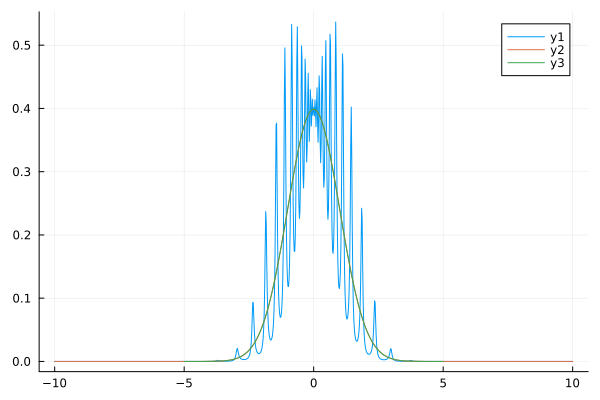

In [10]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [11]:
#=
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
savefig("two_peak.svg")
=#

In [12]:
open("data/gauss_wo_opt.dat","w") do f
    for i in 1:wo_sol.reals.N_real
        println(f, "$(Float64(real.(wo_sol.reals.freq[i])))",  "\t", "$(Float64(imag.(wo_sol.reals.val[i]/pi)))")
    end
end
open("data/gauss_w_opt.dat","w") do g
    for i in 1:sol.reals.N_real
        println(g, "$(Float64(real.(sol.reals.freq[i])))",  "\t", "$(Float64(imag.(sol.reals.val[i]/pi)))")
    end
end
open("data/gauss_exact.dat","w") do h
    for i in 1:length(omegas)
        println(h, omegas[i],  "\t", rho(omegas[i]))
    end
end